In [1]:
%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
linearMesh = uw.mesh.FeMesh_Cartesian('Q1/DQ0', (32,32), (0.,0.), (1.,1.))

In [3]:
constantMesh = linearMesh.subMesh
type(constantMesh)

underworld.mesh._mesh.FeMesh

In [4]:
velocityField = uw.fevariable.FeVariable(linearMesh,2)
velocityField.data[:] = (0.,0.)

In [5]:
pressureField = uw.fevariable.FeVariable(constantMesh,1)
pressureField.data[:] = 0.

In [6]:
# setup freeslip
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
freeslip = uw.conditions.DirichletCondition(velocityField, (IWalls, JWalls))

In [7]:
# setup analytic functions
#solA = fn.analytic.SolCx()
#solA = fn.analytic.SolKx()
solA = fn.analytic.SolKz()

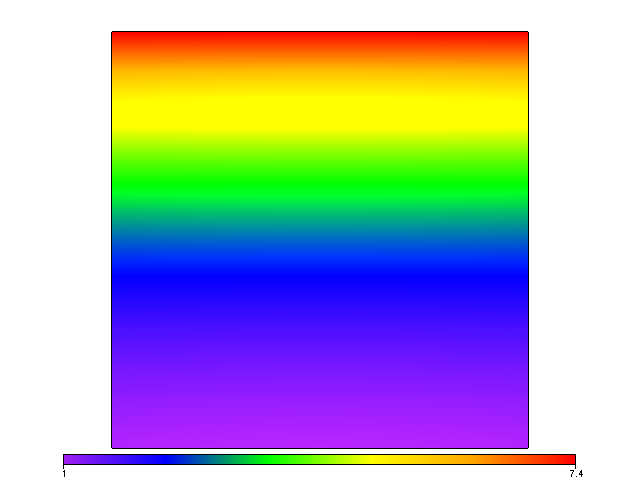

In [8]:
# get eta function from solA and take a look
eta = plt.Figure()
eta.Surface(solA.viscosityFn,linearMesh)
eta.show()

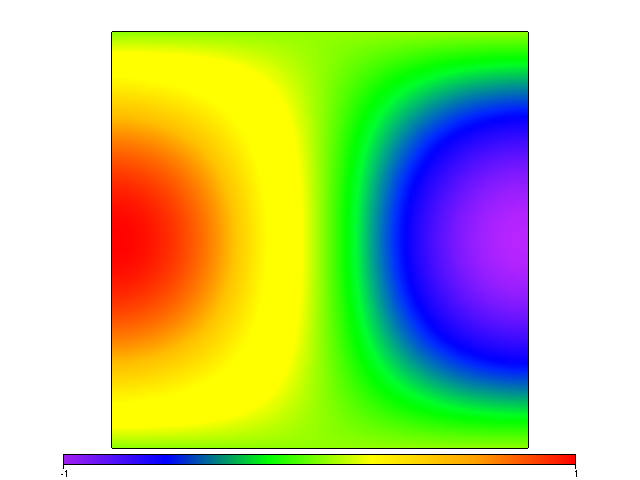

In [9]:
# grab the body force from SolA and take a look at vertical component
force = plt.Figure()
force.Surface(solA.bodyForceFn[1], linearMesh)
force.show()

In [10]:
# setup our stokes guy
stokesSystem = uw.systems.Stokes(velocityField,pressureField,solA.viscosityFn,solA.bodyForceFn,conditions=[freeslip,], rtolerance=1.e-5)

In [11]:
# lets solve
stokesSystem.solve()

In [12]:
# rms
squared = uw.utils.Integral(fn.math.dot(solA.velocityFn-velocityField,solA.velocityFn-velocityField), linearMesh)
area = uw.utils.Integral(1.,linearMesh)
math.sqrt(squared.integrate()[0]/area.integrate()[0])

9.568622018587708e-06

In [13]:
## Compute topography and see how that looks

stresstensorfunc =  2.*solA.viscosityFn*fn.tensor.symmetric( velocityField.gradientFn )
stresstensorfuncA = fn.tensor.deviatoric(solA.stressFn)

surface_deviatoric_stress = stresstensorfunc.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
surface_pressure = pressureField.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
surface_total_stress = surface_deviatoric_stress.T[1]-surface_pressure.T[0]

analytic_surface_deviatoric_stress = stresstensorfuncA.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
analytic_surface_pressure = solA.pressureFn.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
analytic_surface_total_stress = analytic_surface_deviatoric_stress.T[1]-analytic_surface_pressure.T[0]

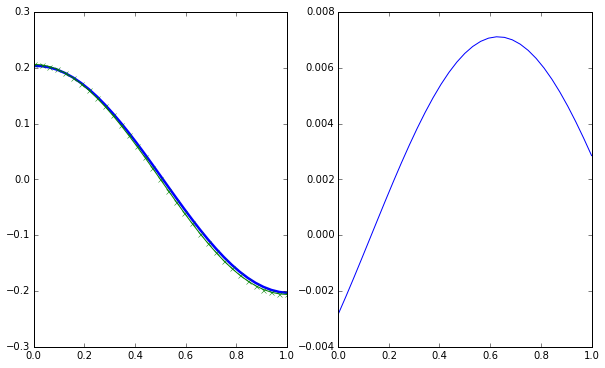

In [14]:

import matplotlib.pyplot as pyplot
from matplotlib import cm
import numpy as np

surface_points_X = linearMesh.data[linearMesh.specialSets["MinJ_VertexSet"].data].T[0]

figure, (plot1, plot2) = pyplot.subplots(1,2)
figure.set_size_inches(10,6)
plot1.plot(surface_points_X, surface_total_stress, linewidth=2.5)
plot1.plot(surface_points_X, analytic_surface_total_stress, marker='x', markersize=5.0)
plot2.plot(surface_points_X, (surface_total_stress-analytic_surface_total_stress))


In [15]:
# Global error measure

def rmsErr(F1, F2):
    """
    Find the rms error between two arrays
    """
    import numpy as np
    
    diff = np.sqrt(( F1-F2 )**2).sum()
    scale = 0.5 * np.sqrt(( F1 )**2).sum() + 0.5 * np.sqrt(( F2 )**2).sum()
    
    try:
        error = diff / scale
    except:
        print "Rms error not available"
        
    return error
        
        
rms_topo_err = rmsErr(analytic_surface_deviatoric_stress, surface_deviatoric_stress)
rms_pressure_err = rmsErr(pressureField.evaluate(linearMesh), solA.pressureFn.evaluate(linearMesh))
rms_velocity_err = rmsErr(fn.math.dot(velocityField,velocityField).evaluate(linearMesh), fn.math.dot(solA.velocityFn,solA.velocityFn).evaluate(linearMesh))

In [16]:
print "Topography error - ", rms_topo_err*100, " %"
print "Pressure error - ", rms_pressure_err*100," %"
print "Velocity (magnitude) error - ", rms_velocity_err*100, " %"

Topography error -  5.61873121613  %
Pressure error -  7.66616098803  %
Velocity (magnitude) error -  0.0553946966319  %


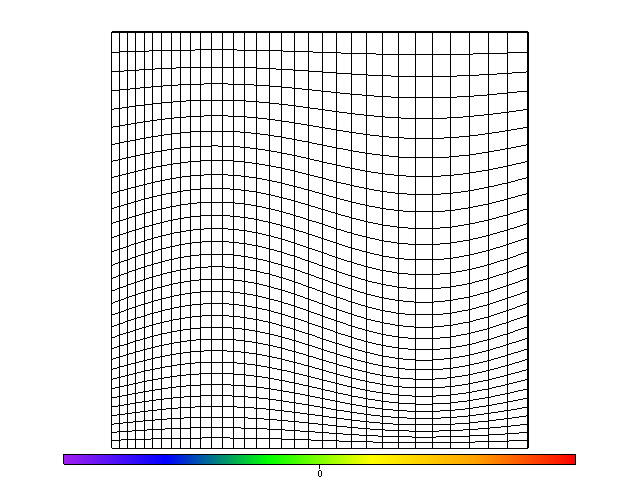

In [17]:
# Now repeat but with a distorted mesh.
# Note any mesh deformations must occur within the 'deform_mesh' context manager
#linearMesh.reset()
with linearMesh.deform_mesh():
    # push the mesh & normalise
    linearMesh.data[:,0] = np.exp(linearMesh.data[:,0])-1.
    linearMesh.data[:,0] /= (linearMesh.data[:,0].max() - linearMesh.data[:,0].min())
    linearMesh.data[:,0] -= linearMesh.data[:,0].min()

    # push the mesh & normalise
    linearMesh.data[:,1] = 0.1*np.sin(linearMesh.data[:,0]*2.0*math.pi)*np.sin(linearMesh.data[:,1]*math.pi) + np.exp(linearMesh.data[:,1])-1.
    linearMesh.data[:,1] /= (linearMesh.data[:,1].max() - linearMesh.data[:,1].min())
    linearMesh.data[:,1] -= linearMesh.data[:,1].min()

meshfig = plt.Figure()
meshfig.Mesh(linearMesh)
stokesSystem = uw.systems.Stokes(velocityField,pressureField,solA.viscosityFn,solA.bodyForceFn,conditions=[freeslip,], rtolerance=1.e-5)
meshfig.show()

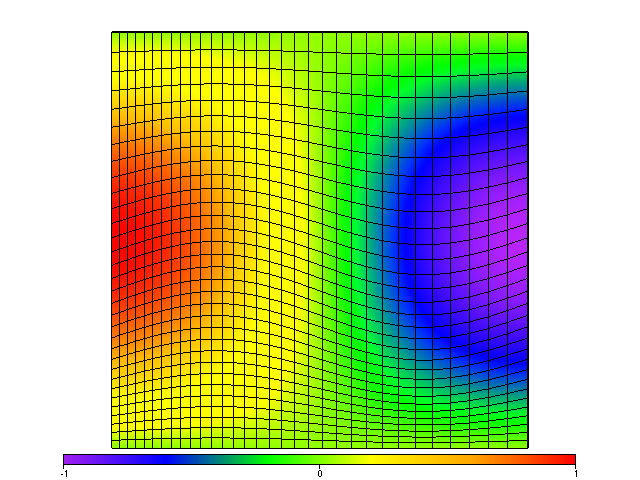

In [18]:
stokesSystem = uw.systems.Stokes(velocityField,pressureField,solA.viscosityFn,solA.bodyForceFn,conditions=[freeslip,], rtolerance=1.e-5)

stokesSystem.solve()

meshfig = plt.Figure()
meshfig.Surface(solA.bodyForceFn[1], linearMesh)
meshfig.Mesh(linearMesh)
meshfig.show()

In [19]:
d_surface_deviatoric_stress = stresstensorfunc.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
d_surface_pressure = pressureField.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
d_surface_total_stress = d_surface_deviatoric_stress.T[1]-d_surface_pressure.T[0]

d_analytic_surface_deviatoric_stress = stresstensorfuncA.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
d_analytic_surface_pressure = solA.pressureFn.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
d_analytic_surface_total_stress = d_analytic_surface_deviatoric_stress.T[1]-d_analytic_surface_pressure.T[0]

d_rms_topo_err = rmsErr(d_analytic_surface_deviatoric_stress, surface_deviatoric_stress)
d_rms_pressure_err = rmsErr(pressureField.evaluate(linearMesh), solA.pressureFn.evaluate(linearMesh))
d_rms_velocity_err = rmsErr(fn.math.dot(velocityField,velocityField).evaluate(linearMesh), fn.math.dot(solA.velocityFn,solA.velocityFn).evaluate(linearMesh))


In [20]:
print "Topography error - ", rms_topo_err*100, " %"
print "Pressure error - ", rms_pressure_err*100," %"
print "Velocity (magnitude) error - ", rms_velocity_err*100, " %"

print "D Topography error - ", d_rms_topo_err*100, " %"
print "D Pressure error - ", d_rms_pressure_err*100," %"
print "D Velocity (magnitude) error - ", d_rms_velocity_err*100, " %"

Topography error -  5.61873121613  %
Pressure error -  7.66616098803  %
Velocity (magnitude) error -  0.0553946966319  %
D Topography error -  34.1144969206  %
D Pressure error -  8.17199748266  %
D Velocity (magnitude) error -  0.0862179260152  %


In [21]:
# an interesting check on the integral is to check if a laterally homogeneous force term results in no flow.